# Deep-LDA: Neural network-based discriminant CVs

Reference paper: _Bonati, Rizzi and Parrinello, [JCPL](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) (2020)_ [[arXiv]](https://arxiv.org/abs/2002.06562). 

## Introduction

The aim of this tutorial is to illustrate how we can design collective variables in a data-driven way, starting from local fluctuations of a set of physical descriptors in the metastable states. For applying these methods we will only need to have samples from different metastable states (typically obtained by MD simulations starting from e.g. reactants and products).

**Linear Discriminant Analysis**

To this extent, we resort to a statistical method called Linear Discriminant Analysis ([LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)). LDA searches for the linear projection $s=\bar{w}^T x$ of the input data $x$ such that the classes are maximally separated. The parameters are obtained by maximizing the so called Fisher's ratio of the between-class variance $\mathbf{S}_b$ to the within-class variance $\mathbf{S}_w$ 

$$\bar{w} = \text{argmax}_w {\frac{wS_b w^T}{wS_w w^T}}$$

The within class variance (or scatter) matrix is defined as the average of class covariances: 
$$\mathbf{S}_w = \frac{1}{n_c} \sum_c \mathbf{C}_c $$

while the between class one is defined as the covariance of class means $\boldsymbol{\mu}_c$: 
$$\mathbf{S}_b = \frac{1}{n_c} \sum_c (\boldsymbol{\mu}_c -\boldsymbol{\mu})(\boldsymbol{\mu}_c -\boldsymbol{\mu})^T$$

where $\boldsymbol{\mu}$ denotes their average. 

In the simple case of two classes (states) A and B these can be easily computed from the mean and covariance matrices of the data in the states:

$$\mathbf{S}_w = C_A + C_B $$

$$\mathbf{S}_b = (\mu_A-\mu_b)(\mu_A-\mu_b)^T $$

<center><img src="images/lda.png" width="300" /></center>

The discriminant components $\{\mathbf{v}_i\}$ are obtained by solving the generalized eigenvalue problems:
\begin{equation}
\mathbf{S}_b\mathbf{v}_i = \mathbf{S}_w\lambda_i^{(lda)} \mathbf{v}_i
\end{equation}
where the eigenvalues $\lambda_i^{(lda)}$ measure the amount of separation between the states along the i-th component. Note that for LDA the number of output components is determined by the number of non-zero eigenvalues which is equal to the number of classes $n_C - 1$. 

An harmonic variant, called HLDA, has been proposed for CV discovery, where the within-scatter matrix is calculated from the harmonic mean of the class covariances:
$$\mathbf{S}_w ^{-1} = \frac{1}{n_c} \sum_c \mathbf{C}_c ^{-1} \$$

**Neural networks-based LDA**

<center><img src="images/deeplda.png" width="800" /></center>

A non-linear generalization of LDA can be obtained by transforming the input features via a neural network (NN), and then performing LDA on the NN outputs. In this way, we are transforming the input space in such a way that the discrimination between the states is maximal. During the training, the parameters are optimized to maximize the LDA eigenvalues $\mathbf\lambda$:

\begin{equation}
\mathcal{L}_{DeepLDA}=-\sum_{c=1} ^{n_c-1} \lambda_c^{(lda)} + \text{reg}_{lor}
\end{equation}
with $\text{reg}_{lor}=\alpha \left( 1+( \mathbb{E}\left[||\mathbf{s}||^2\right]-1)^2 \right)^{-1}$ being a Lorentzian regularization acting on the average of the output CVs keeping its norm close to 1, to make the objective function bounded. Note that, in the case of two states, Fisher's loss is equal to the single eigenvalue, while in the multiclass one, we have $n_C-1$ of them. In the latter case, we could also maximize another (monotonic) function of the eigenvalues, such as the sum of squares or even just the smallest eigenvalue.

Note that to stabilize the learning we also regularize the calculation of $S_w$ by adding the identity matrix multiplied by a parameter $\beta$, as: $S_w '= S_w+\beta\mathbb{1}$ . The two regularization parameters $\alpha$ and $\beta$ are not independent, as the former affects the numerator of the Fisher's ratio above and the latter the denominator. Hence, in the following, we will choose only $\beta$ and set $\alpha=\frac{2}{\beta}$.

## Setup

In [7]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

## Muller-Brown potential

In this first example we train a CV for the Muller-Brown 2D potential, using labeled samples collected from MD simulations started in the two basins. 

### Load MD data

In [8]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)

 - Loaded dataframe (4002, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


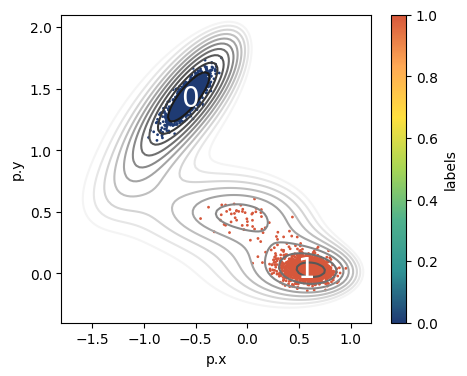

In [9]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


Prepare dataset

In [10]:
# get inputs X and labels
X = dataset[:]['data']
labels = dataset[:]['labels']

print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([4002, 2])
labels: torch.Size([4002])


### LDA

We can optimize an LDA variable from the `core.stats` module. We only need to initialize it and call the compute method.

In [11]:
from mlcolvar.core.stats import LDA

# define LDA object 
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='standard')

# compute vectors that most discriminate the states
eigvals, eigvecs = lda.compute(X,labels)

The discriminant component is given by the linear combination along the eigenvector, with coefficients:

In [12]:
print(eigvecs)

tensor([[ 0.3874],
        [-0.9219]])


The direction can be easily visualized in the 2D space by plotting its isolines together with the ones of the potential. Remember that the additional force acting on the CV will drive the system in the direction orthogonal to the isolines of the CVs.

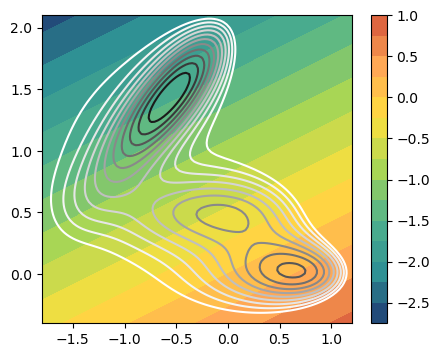

In [ ]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(lda, component=i, levels=15, ax=ax)

### HLDA (harmonic variant)

To use the harmonic variant (in which the within-scatter matrix is calculated with an harmonic mean), we just need to select the `mode=harmonic` when initializing the CV.

In [ ]:
# define HLDA object 
hlda = LDA(in_features=X.shape[1], n_states=n_states, mode='harmonic')

# compute vectors that most discriminate the states
eigvals, eigvecs = hlda.compute(X,labels)

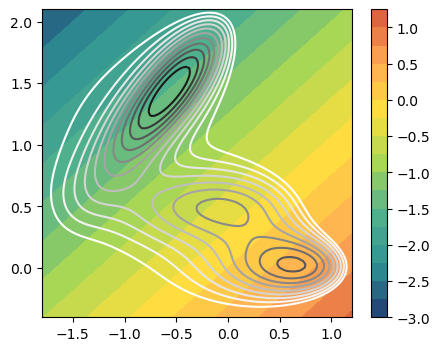

In [ ]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(hlda, component=i, levels=15, ax=ax)

### Deep-LDA: maximizing LDA eigenvalues

To optimize a NN to maximize the discriminative power of LDA we need to wrap the dataset inside a datamodule and define the corresponding DeepLDA CV. 

#### Create datamodule

In [ ]:
# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

DictModule(dataset -> DictDataset( "data": [4002, 2], "labels": [4002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

#### Define model

In [ ]:
from mlcolvar.cvs import DeepLDA

n_components = n_states-1
nn_layers = [2,30,30,5]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepLDA(nn_layers,n_states=n_states, options=options)

#### Define Trainer & Fit

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_ep

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 686: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=16] 


After the training we can monitor the evolution of the LDA eigenvalue over the epochs.

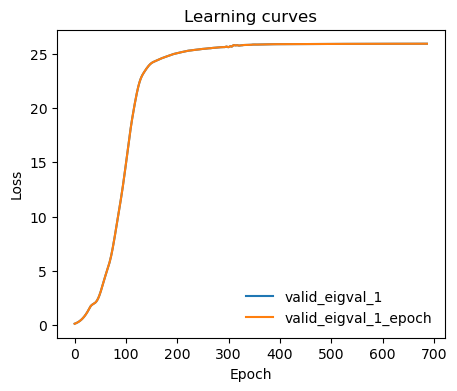

In [ ]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Analysis of the CV

Here we compare the LDA vs DeepLDA CVs through their isolines as well as the histograms of the CVs. The latter is able to maximize the discriminative power of the CVs.

Text(0.5, 1.0, 'DeepLDA')

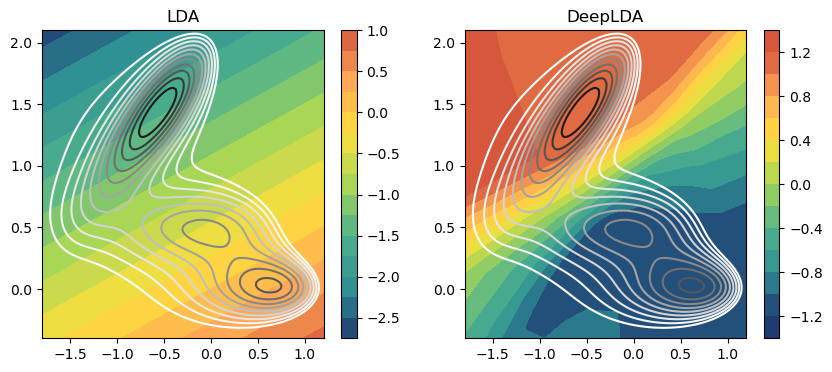

In [ ]:
fig,axs = plt.subplots( 1, 2, figsize=(5*2,4) )

# LDA
ax = axs[0]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(lda, component=i, levels=15, ax=ax)
ax.set_title('LDA')

# Deep-LDA
ax = axs[1]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, component=i, levels=15, vmin=-1.2,vmax=1.2, ax=ax)
ax.set_title('DeepLDA')

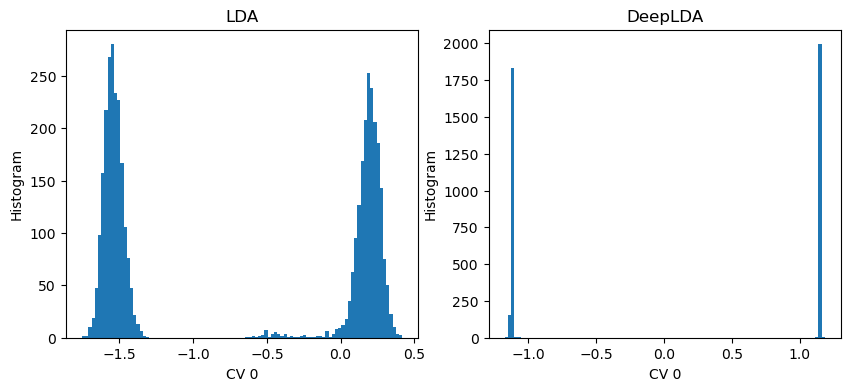

In [ ]:
fig,axs = plt.subplots( 1, 2, figsize=(5*2,4) )

titles = ['LDA','DeepLDA']

for (m, ax, title) in zip([lda,model],axs,titles):

    X = dataset[:]['data']
    with torch.no_grad():
        s = m(torch.Tensor(X)).numpy()

    ax.hist(s[:,0],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')
    ax.set_title(title)

## Alanine dipeptide

In this second example we train a DeepLDA CV on the alanine dipeptide data, which was one of the examples of the [DeepLDA paper](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535). As input features we will use the 45 distances between heavy atoms. 

### Load data

We use the alanine dipeptide simulation data from the [PLUMED-MASTERCLASS](https://github.com/luigibonati/masterclass-plumed/) repository.

In [ ]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR", 
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'d_' }, # select distances between heavy atoms
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

We can inspect the distances through their histograms, from which we notice that no one is able to discriminate between the states.

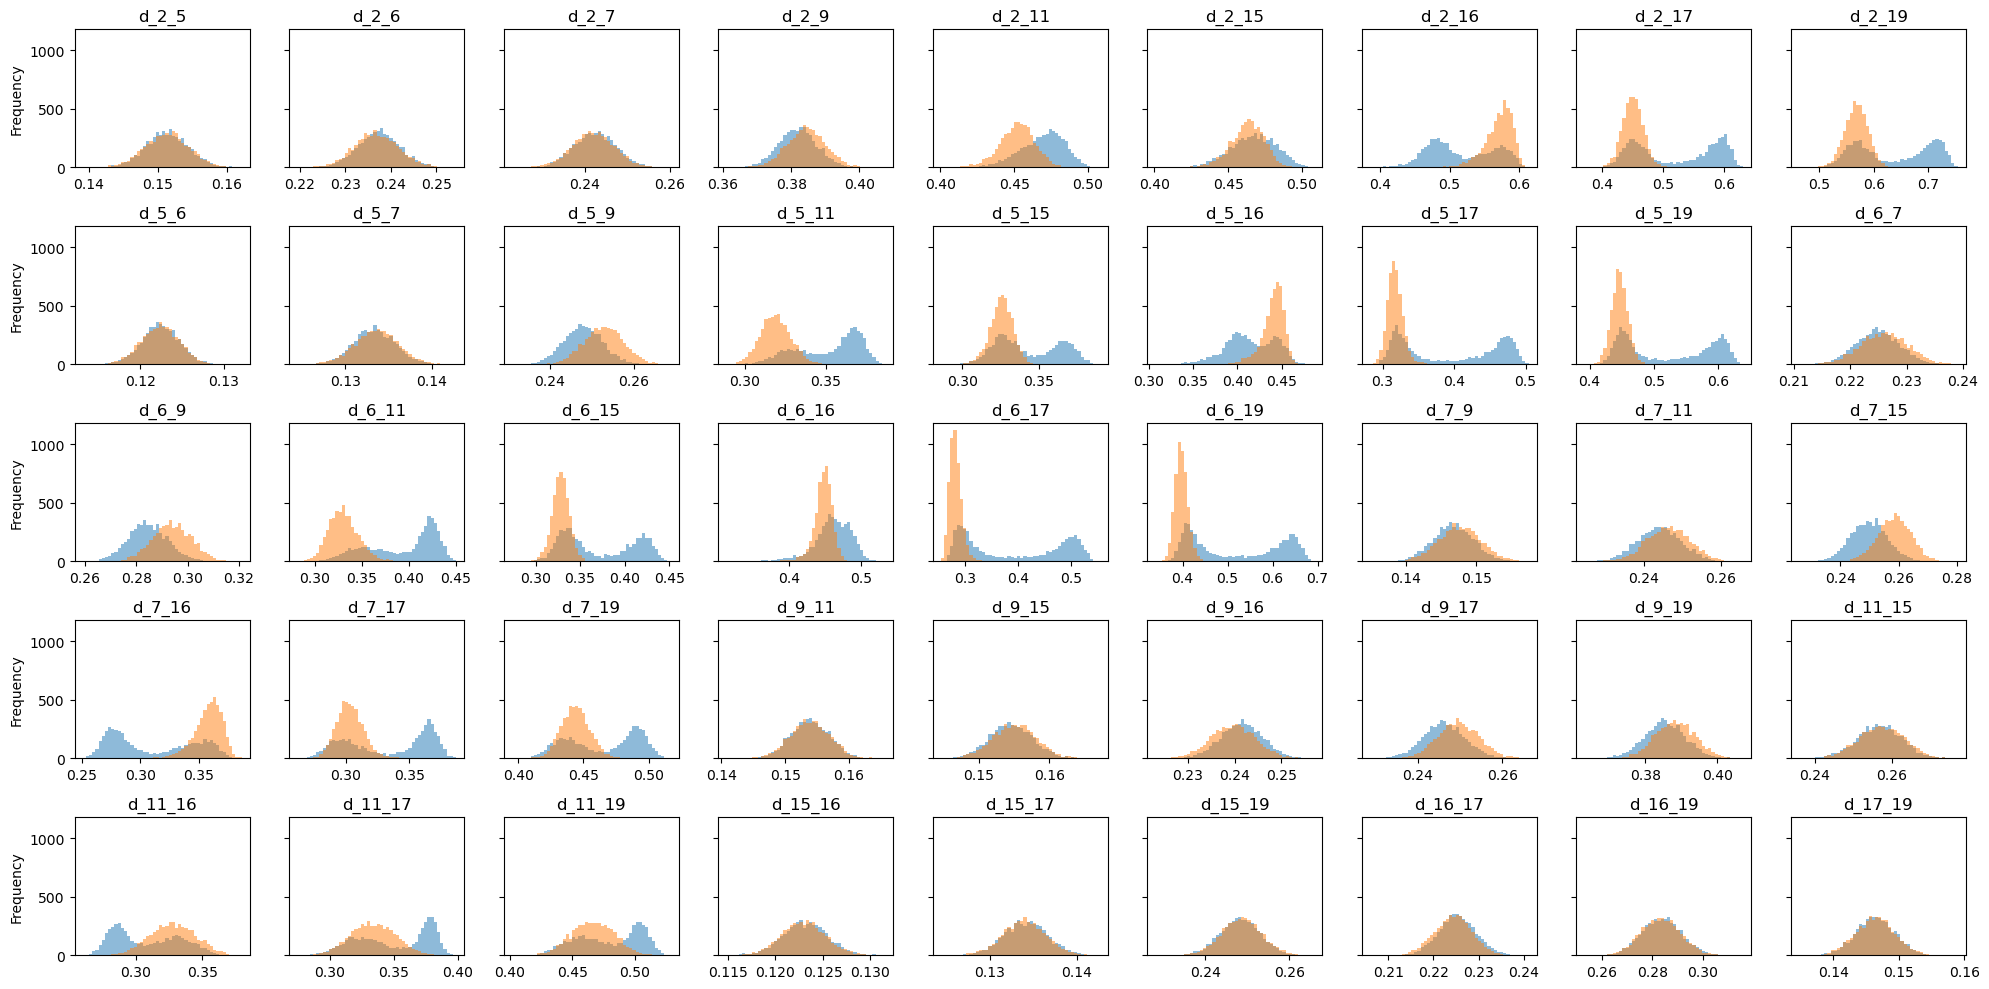

In [ ]:
descriptors_names = df.filter(regex='d_').columns.values

fig,axs = plt.subplots(5,9,figsize=(20,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    df.pivot(columns='labels')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

### Train DeepLDA 

Define CV

In [ ]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [n_input,30,30,2]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

model

DeepLDA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (lda): LDA(in_features=2, out_features=1)
)

Define trainer and fit

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenva

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 269: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s, v_num=18] 


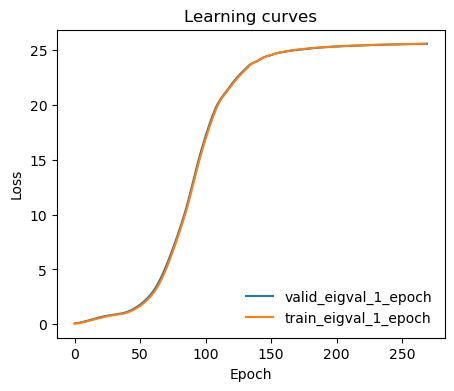

In [ ]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')

#### Analysis of the CV

In [ ]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i] 

As in the previous example, we can evaluate the histogram of the CV on the training set, from which we see how the two states are now discriminated. 

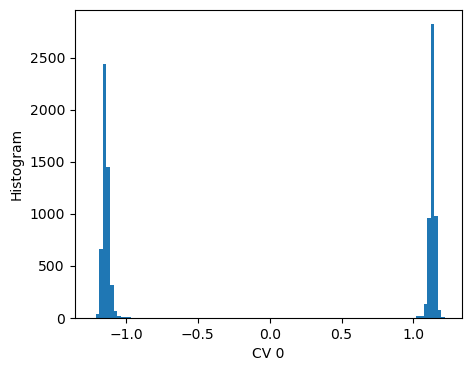

In [ ]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

Moreover, we can also visualize the CVs values on a physical space, e.g. in the Ramachandran plot ($\phi$ and $\psi$ space).

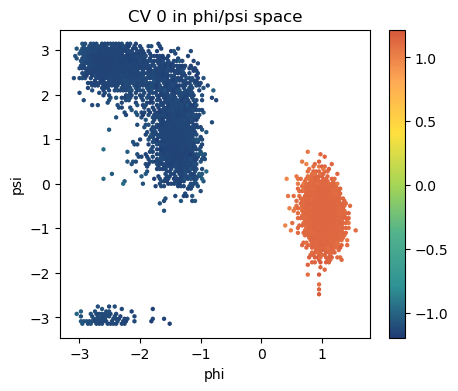

In [ ]:
n_components = n_states-1

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='fessa',ax=ax)
    ax.set_title(f'CV {i} in phi/psi space')

By performing an enhanced sampling simulation along the CV we can we can compute the free energy profile and compare the isolines in the whole Ramachandran plot, which show how the DeepLDA CV captures approximately the minimum free energy pathway connecting the two states.

<center><img src="images/ala2-deeplda.png" width="500" /></center>

## Aldol reaction

We can train a CV also for the other example reported in the paper, which is an intermolecular aldol reaction between vinyl alcohol and formaldehyde.

We download the data from the [DeepLDA repository](https://github.com/luigibonati/data-driven-CVs/) associated to the [PLUMED-NEST](https://www.plumed-nest.org/eggs/20/004/) submission, which contains unbiased simulations of the reactants and products.

<center><img src="images/aldol-R.jpg" width="500" /><img src="images/aldol-P.jpg" width="500" /></center>

### Load data

In [14]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.R", 
              "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.P" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'cc|oo|co|ch|oh' }, # select contacts 
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 43)
Class 1 dataframe shape:  (5001, 43)

 - Loaded dataframe (10002, 43): ['time', 'cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11', 'walker', 'labels']
 - Descriptors (10002, 40): ['cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11']


### Train DeepLDA CV

In [20]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [n_input,30,30,5]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

model

DeepLDA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=40, out_features=40, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=5, bias=True)
    )
  )
  (lda): LDA(in_features=5, out_features=1)
)

In [21]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEige

/home/lbonati@iit.local/software/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 318: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s, v_num=50] 


Monitor learning curves

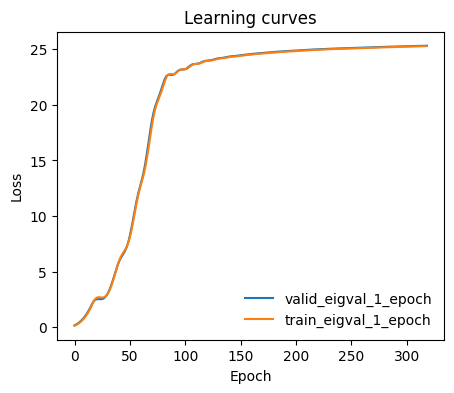

In [22]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')

#### Analysis of the CV

In [23]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i] 

We can evaluate the histogram of the CV on the training set, from which we see how the two states are well discriminated. 

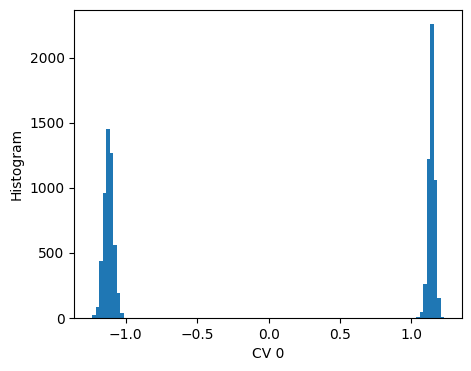

In [19]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

This CV can be then exported and used with the input files deposited on the [PLUMED-NEST](https://www.plumed-nest.org/eggs/20/004/) repository to enhance sampling of the aldol reaction!

<center><img src="images/aldol-deeplda.png" width="600" /></center>

TODO: perform the sensitivity analysis on the descriptors as done in the DeepLDA colab notebok